#### Downloading the MNIST dataset from sklearn

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [4]:
X, y = mnist['data'], mnist['target']

The dataset contains 70 000 images, each image contain 28 * 28 = 784 features

In [5]:
X.shape

(70000, 784)

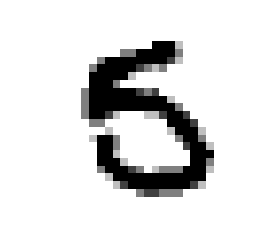

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[32000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[32000]

5.0

#### Creating the test set and the training set

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
import numpy as np
random_shuffle = np.random.permutation(60000)
X_train, y_train = X_train[random_shuffle], y_train[random_shuffle]

## Binary Classifier

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

We choose Stochastic Gradient Descent, as it works pretty well with large datasets, since it calculates gradiant's only on a mini-batch of the set.             
Also, since SGD relies on randomness to choose the mini-batch, we should fix the random state if we want to have the same results

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([False])

#### Measuring the classifier perfomance

Creating a custom Cross-Validation

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfold.split(X_train, y_train_5):
    sgd_clone = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    X_test_fold = X_train[test_index]
    y_train_fold = y_train_5[train_index]
    y_test_fold = y_train_5[test_index]
    sgd_clone.fit(X_train_fold, y_train_fold)
    
    y_pred = sgd_clone.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

0.9649
0.9647
0.95815


Using the built-in CV

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy', verbose=100)

[CV]  ................................................................
[CV] ................................... , score=0.9649, total=   0.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[CV]  ................................................................
[CV] ................................... , score=0.9647, total=   0.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[CV]  ................................................................
[CV] .................................. , score=0.95815, total=   0.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


array([0.9649 , 0.9647 , 0.95815])

95% accuracy predicition, pretty amazing isn't ?, well let's see

#### Building a "dumb" classifier

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Measuring the classifier performance

In [16]:
never_5_clf = Never5Classifier()
never_5_clf.fit(X_train)
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy', verbose=100) 

[CV]  ................................................................
[CV] .................................. , score=0.90855, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV]  ................................................................
[CV] ................................... , score=0.9085, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[CV]  ................................................................
[CV] ................................... , score=0.9119, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


array([0.90855, 0.9085 , 0.9119 ])

above 90% accuracy...., something fishy is happening...

It's due to the fact that only 10% of the images are actually 5's, so if you always guess that an image is not a 5, you will be right 90% of the time.

This demonstrates why accuracy is generally not the prefered performance measure for classification, especially when we're dealing with skewed databases (i.e. when some classes are much more frequent than some other classes)

#### Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, verbose=100)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished


In [18]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53691,   888],
       [ 1357,  4064]], dtype=int64)

In [20]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Precision: when the classifier claims it's a 5, and it is indeed a 5, $\frac{TP}{TP+FP}$.       
Recall: when the classifier detects a 5, $recall = \frac{TP}{TP + FN}$.

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8206785137318255

In [22]:
recall_score(y_train_5, y_train_pred)

0.7496771813318576

f1_score if want to compare two classifiers, it combines both scores, $F1 = \frac{2}{ \frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}$.

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7835727369131398

depending on the case, we might prefer increasing precision over recall (classifing content videos for kids), or vice versa (detecting shoplifters).

#### Precision/Recall Tradeoff

The way the classifier assigns an observation to a class, is by affecting a score, if the score is higher than a certain threshold, than the observation indeed belongs that class, otherwise no, therefor, by increasing the threshold, we increase the precision of our classifier, and by decreasing it we increase his recall performance.

sklearn doesn't let us set the threshold, directly, but we have access to decision_function associated to the classifier

In [24]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([-132987.93712269])

In [25]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

In [26]:
threshold = 250000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

#### Deciding the threshold

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([-485579.45889419,  -21541.47860575, -492642.82736866, ...,
       -160550.45495587, -441670.75903698, -327180.13968066])

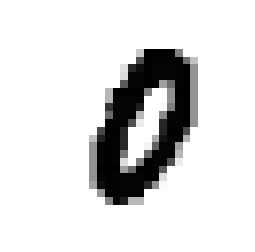

In [28]:
def plot_index(index):
    digit = X[index].reshape(28, 28)
    plt.imshow(digit, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
plot_index(2)
plt.show()

In [29]:
from sklearn.metrics import precision_recall_curve
precisions, recalls ,thresholds = precision_recall_curve(y_train_5, y_scores)
y_train_5.shape

(60000,)

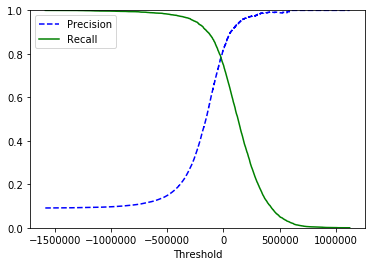

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.ylim([0, 1])
    plt.legend(loc="upper left")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

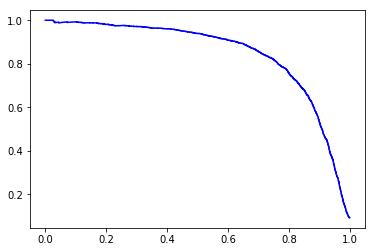

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-')
plot_precision_vs_recall(precisions, recalls)
plt.show()

If we want a precision over 90%, we can select ~ 150000 as a threshold, there for, we don't use the defaut predict method, we use:

In [32]:
y_train_pred_90 = (y_scores > 150000)
precision_score(y_train_5, y_train_pred_90)

0.948971820258949

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4596937834347906

Now we only have to select the precision that fits best our project, but becareful, a high precision classifier is not useful if it's recall is too low

#### The ROC Curve

Very similar to Precision/Recall(PR) curve, but it plots true positive rate (another name for recall), against false positive rate, which is 1 - true negative rate, which is the ratio of negative instances, which are correctly classified as negatives


In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

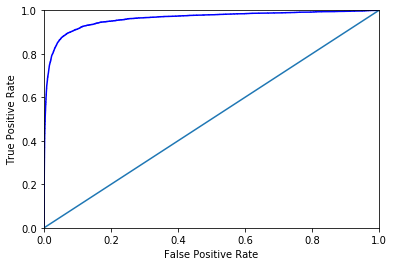

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, 'b-',label=label)
    plt.plot([0,1])
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
plot_roc_curve(fpr, tpr)
plt.show()

The straigth line represents a purely random classifier, the further the classifier for that line, the better it is (towards the top corner of course)

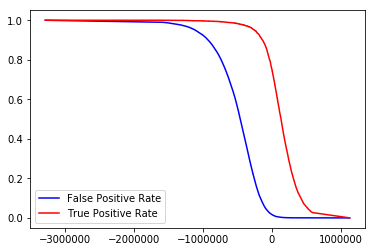

In [36]:
def plot_fpr_tpr_vs_threshold(fpr, tpr, threshold):
    plt.plot(threshold, fpr, 'b-', label="False Positive Rate")
    plt.plot(threshold, tpr, 'r-', label="True Positive Rate")
    plt.legend()
plot_fpr_tpr_vs_threshold(fpr, tpr, threshold)
plt.show()

One way to compare classifiers is to measure the Area Under Curve (AUC), a perfect classifier will have ROC AUC = 1, wherease purely random one will have 0.5

In [37]:
y_scores

array([-485579.45889419,  -21541.47860575, -492642.82736866, ...,
       -160550.45495587, -441670.75903698, -327180.13968066])

In [38]:
from sklearn.metrics import roc_auc_score #Notice that we take the scores given by the decision function of our classifier
roc_auc_score(y_train_5, y_scores)

0.9619834044944976

PR vs ROC: we use PR when the positive class are pretty rare, or when we care more about the false positive than the false negative, and the ROC otherwise.

#### Training a Random Forest classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[1. , 0. ],
       [0.3, 0.7],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

roc_curve varies threshold, and for each value it computes the fpr and the tpr (same for precision_recall_curve)

In [40]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold = roc_curve(y_train_5, y_scores_forest)

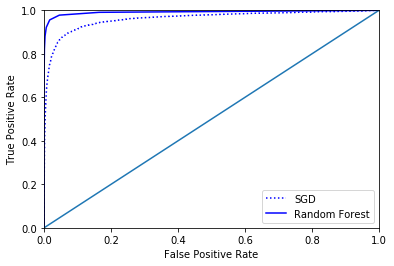

In [41]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9918758134134276

In [43]:
y_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, verbose=100)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s finished


In [44]:
precision_score(y_train_5, y_forest_pred)

0.9877913429522752

In [45]:
recall_score(y_train_5, y_forest_pred)

0.8208817561335547

## Multiclass Classification

To train strictly binary classifier as a Multiclass Classifier we can :
* OvA (*one-versus-all*): Train $N$ Binary Classifier, $N$ is the number of classes, (in our case 10, from 0 to 9), and for the predicition we take the classe have the highest decision function score
* OvO (*one-versus-one*) : Train $N(N+1)/2$ Binary classifier, and see which classe win most of the duel.

The main advantage of OvO is that each classifier runs on only a part of the dataset, the two classes which must distinguish from, making it perfect of algorithms which scales poorly with size, like Support Vector Machines, which runs in $O((data\_size)^3)$.

Sklearn detect automatically When we use a binary classifier and automatically runs OvA, (except for SVM where it runs OvO)

In [46]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([8.])

In [47]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-137312.16899216, -690525.89575286, -694195.9746982 ,
        -564569.26929765, -746240.77662372, -132987.93712269,
        -161369.18624079, -725597.7530679 ,  -42419.83554202,
        -756242.09645097]])

In [48]:
np.argmax(some_digit_scores)

8

In [49]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [50]:
sgd_clf.classes_[5]

5.0

Forcing SciKitLearn to use OvO

In [51]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(sgd_clf)
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [52]:
len(ovo_clf.estimators_)

45

Training a RandomForest, here sklearn won't use OvO/OvA since it RandomForest is a multiclass Classifier

In [53]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [54]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0.1, 0. ]])

Now let's evaluate our models

In [55]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy',verbose=100)

[CV]  ................................................................
[CV] ....................... , score=0.8788242351529694, total=   2.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[CV]  ................................................................
[CV] ........................ , score=0.872143607180359, total=   2.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8634795219282893, total=   2.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s finished


array([0.87882424, 0.87214361, 0.86347952])

In [56]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring='accuracy', verbose=100)

[CV]  ................................................................
[CV] ....................... , score=0.9131673665266946, total=  13.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s
[CV]  ................................................................
[CV] ....................... , score=0.9064953247662383, total=  12.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.8s remaining:    0.0s
[CV]  ................................................................
[CV] ....................... , score=0.9107866179926989, total=  13.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.5s finished


array([0.91316737, 0.90649532, 0.91078662])

In [57]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy', verbose=100)

[CV]  ................................................................
[CV] ....................... , score=0.9418616276744651, total=   3.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[CV]  ................................................................
[CV] ....................... , score=0.9404970248512425, total=   3.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[CV]  ................................................................
[CV] ....................... , score=0.9414912236835525, total=   3.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s finished


array([0.94186163, 0.94049702, 0.94149122])

We can scale the input to get slightly better results

In [58]:
from sklearn.preprocessing import StandardScaler #on the cell, which represents the pixels, since they vary between 0 and 255.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [59]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy', verbose=100)

[CV]  ................................................................
[CV] ........................ , score=0.911617676464707, total=   2.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[CV]  ................................................................
[CV] ....................... , score=0.9086954347717386, total=   2.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[CV]  ................................................................
[CV] ....................... , score=0.9094864229634445, total=   2.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s finished


array([0.91161768, 0.90869543, 0.90948642])

## Error Analysis

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5602,    2,   39,   27,   19,   63,   69,    8,   81,   13],
       [   1, 6387,   75,   27,    8,   52,   10,   15,  151,   16],
       [  83,   30, 5264,  111,   88,   34,   69,   52,  186,   41],
       [  46,   19,  250, 5061,   25,  380,   19,   53,  168,  110],
       [  12,   15,   26,    6, 5277,   29,   27,   11,   64,  375],
       [  54,   20,   63,  140,   99, 4459,  114,   13,  359,  100],
       [  56,   10,   66,   11,   96,  123, 5493,    1,   54,    8],
       [  18,   17,   81,   50,  124,   25,    7, 5446,   62,  435],
       [  65,  115,  137,  175,  108,  529,   70,   32, 4453,  167],
       [  49,   17,   28,   81,  457,  133,    3,  195,  139, 4847]],
      dtype=int64)

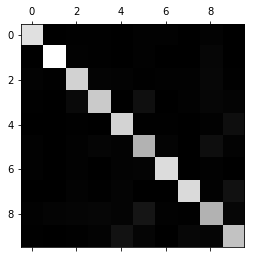

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Pretty cool, cells on the main diagonal is way brigther than the others, which is promising.

Now let's focus on the errors.

In [62]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums #since some classes might be rarer than others

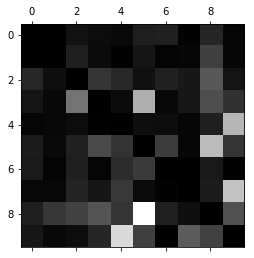

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [64]:
cl_a, cl_b = 9, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [65]:
def plot_digits(instances, images_per_row, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, -1) for instance in instances]
    n_row = (len(instances) - 1) // images_per_row + 1
    n_empty = n_row * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    row_images = []
    for row in range(0, n_row):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    row_images = np.concatenate(row_images, axis=0)
    plt.imshow(row_images, cmap=matplotlib.cm.binary, **options)
    plt.axis('off')

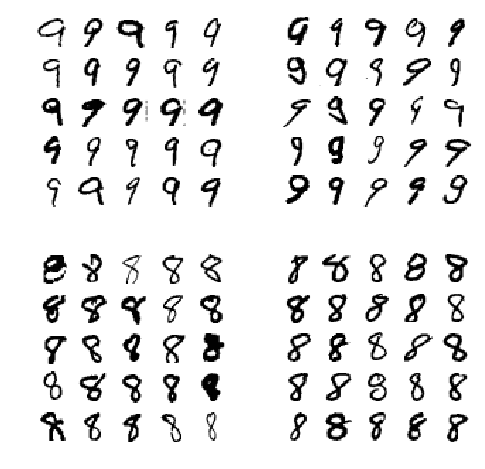

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

When the input could have one or many labels associated to it.

In [67]:
from sklearn.neighbors import KNeighborsClassifier #Not all classifier supports multilabel classifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3, verbose=100)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 37.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 56.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 56.0min finished


In [69]:
f1_score(y_train, y_train_knn_pred,average='macro')

0.9689516823059099

## Multioutput Classification

It's a generalization of the *multilabel classificiation* where each label can be multiclass.

For example, a classifier that cleans noise from images, it's multilabel since there's a label for each pixel, in the output, but also each label can take a value between 0 and 255

In [70]:
noise = np.random.randint(0, 100, (len(X_train), len(X_train[0])))
X_train_mod = X_train + noise
y_train_mod = X_train
noise = np.random.randint(0, 100, (len(X_test), len(X_test[0])))
X_test_mod = X_test + noise
y_test_mod = X_test

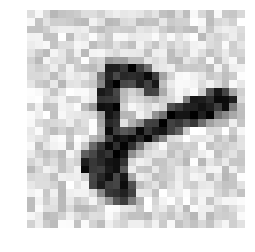

In [71]:
plot_digits([X_train_mod[0]], images_per_row=1)

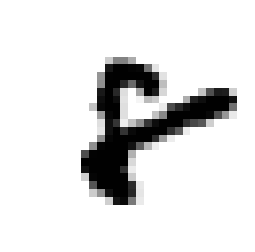

In [72]:
plot_digits([X_train[0]], images_per_row=1)

In [73]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

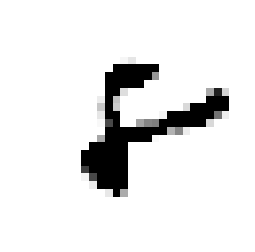

In [74]:
clean_digit = knn_clf.predict([X_train_mod[0]])
plot_digits([clean_digit], images_per_row=1)

## A MNIST Classifier with over 97% accuracy

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = { 'n_neighbors' : [3, 4, 5], 'weights' : ['uniform', 'distance']}

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, scoring='accuracy', cv=3, verbose=100)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.9693061387722456, total=24.0min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 68.4min remaining:    0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.9694984749237462, total=22.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 136.9min remaining:    0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.9706455968395259, total=27.5min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 212.3min remaining:    0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9703059388122376, total=21.4min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 286.9min remaining:    0.0s
[CV] n_neighbors=3, 

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=100)

In [77]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

## Data Augmetation

We can artificially increase the size of our training, to make our models perform better.

For our dataset, we can shift the images slightely in each direction.

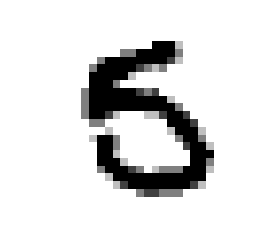

In [72]:
plot_digits([some_digit], images_per_row=1)

In [73]:
def lift_images_up(instances):
    instances_up = [np.r_[instance.reshape(28, -1)[3:], np.zeros((3, 28))].reshape(1, -1) for instance in instances]
    return np.array(instances_up).reshape(len(instances), -1)

In [74]:
def lift_images_down(instances):
    instances_down = [np.r_[np.zeros((3, 28)), instance.reshape(28, -1)[3:]].reshape(1, -1) for instance in instances]
    return np.array(instances_down).reshape(len(instances), -1)

In [75]:
def lift_images_left(instances):
    instances_left = [np.r_[instance.reshape(28, -1).transpose()[3:], np.zeros((3, 28))].transpose().reshape(1, -1) for instance in instances]
    return np.array(instances_left).reshape(len(instances), -1)

In [76]:
def lift_images_right(instances):
    instances_right = [np.r_[np.zeros((3, 28)), instance.reshape(28, -1).transpose()[:25]].transpose().reshape(1, -1) for instance in instances]
    return np.array(instances_right).reshape(len(instances), -1)

In [77]:
X_train_up = lift_images_up(X_train)

In [78]:
X_train_down = lift_images_down(X_train)

In [79]:
X_train_left = lift_images_left(X_train)

In [80]:
X_train_right = lift_images_right(X_train)

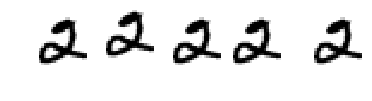

In [81]:
plot_digits([X_train[0], X_train_up[0], X_train_down[0], X_train_left[0], X_train_right[0]], images_per_row=5)

In [82]:
X_train.shape

(60000, 784)

In [83]:
X_train_augmented = np.r_[X_train, X_train_left, X_train_right, X_train_up, X_train_down]

In [84]:
X_train_augmented.shape

(300000, 784)

In [111]:
y_train_augmented = np.r_[y_train, y_train, y_train, y_train, y_train]

In [112]:
y_train_augmented.shape

(300000,)

Training using the normal dataset

In [85]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')

In [86]:
y_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3, verbose=100)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 50.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 69.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 69.4min finished


In [87]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_knn_pred)

0.9722833333333334

In [113]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')